### Author: Ally Sprik
### Last-updated: 25-02-2024

Goal of this notebook is to generate results for my paper, in specific a comparison between the models trained on the original and extended training sets. The results will be presented in a ROC curve and the AUC will be calculated. The data used for this comparison is the Brno and Tubingen data. The data is cleaned and the models are fitted. The fitted models are used to generate the probabilities for the LNM and Survival. The probabilities are used to generate the ROC curves and calculate the AUC

In [1]:
import pandas as pd
import numpy as np
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from collections import Counter

pd.options.mode.copy_on_write = True  # This will allow the code to run faster and keep Pandas happy. Technical detail: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#

net1 = gum.loadBN("../../1.3. Model/Fitted_Networks/R_WP_763.net")
net2 = gum.loadBN("../../1.3. Model/Fitted_Networks/R_WP_952.net")

df_brno = pd.read_csv("../../../0. Source_files/0.2. Cleaned_data/Cleaned_Brno_model_complete.csv")
df_tubingen = pd.read_csv("../../../0. Source_files/0.2. Cleaned_data/Tubingen_Validation_wMSI.csv")

Data cleaning and preparation

In [2]:
df_brno_LNM = df_brno.dropna(subset=["LNM"])
df_brno_surv = df_brno.dropna(subset=["Survival5yr"])
LNM_target_brno = df_brno_LNM["LNM"].replace({"yes": 1, "no": 0})
Surv_target_brno = df_brno_surv["Survival5yr"].replace({"yes": 1, "no": 0})

df_tubingen_LNM = df_tubingen.dropna(subset=["LNM"])
df_tubingen_surv = df_tubingen.dropna(subset=["Survival5yr"])
LNM_target_tubingen = df_tubingen_LNM["LNM"].replace({"yes": 1, "no": 0})
Surv_target_tubingen = df_tubingen_surv["Survival5yr"].replace({"yes": 1, "no": 0})

Pseudocode:
- Create a function that takes a model, evidence for LNM and evidence for Survival as input
    - Create an empty list for the results
    - For each row in the evidence for LNM
        - Get the evidence for the row
        - Set the evidence in the model
        - Make the inference
        - Get the posterior for LNM
        - Append the result to the list
    - For each row in the evidence for Survival
        - Get the evidence for the row
        - Set the evidence in the model
        - Make the inference
        - Get the posterior for Survival
        - Append the result to the list
    - Return the list


In [3]:
def getProbabilities(model, evidence_LNM, evidence_Surv, Surv="Survival5yr", samples=100):
    ls_result_LNM = []
    ls_result_Surv = []

    #for i in range(1, samples):
    resultsLNM = []
    resultsSurvival = []
    net = gum.LazyPropagation(model)
    net.getNumberOfThreads()
    net.setNumberOfThreads(10)

    for j in range(len(evidence_LNM)):
        evidencerow = evidence_LNM.iloc[j]
        evidencerow = evidencerow.dropna().to_dict()

        try:
            net.setEvidence(evidencerow)

            net.makeInference()

            resultLNM = net.posterior("LNM")

            resultsLNM.append(resultLNM)
        except Exception as error:
            print("Error at row regarding LNM", j)
            print(error)

            resultsLNM.append(resultLNM)

    for j in range(len(evidence_Surv)):
        evidencerow = evidence_Surv.iloc[j]
        evidencerow = evidencerow.dropna().to_dict()

        try:
            net.setEvidence(evidencerow)

            net.makeInference()

            resultSurvival = net.posterior("Survival5yr")

            resultsSurvival.append(resultSurvival)
        except Exception as error:
            print("Error at row regarding Survival", j)
            print(error)

            resultsSurvival.append(resultSurvival)

    return resultsLNM, resultsSurvival


def getProbResults(results, target):
    res = []

    for i in range(len(results)):
        res.append(results[i][target])
    return pd.DataFrame(res)




Psuedocode:
- Create a function that takes the results and the targets as input
    - Check if the length of the results and the targets are the same
    - Get the ROC AUC, Log Loss, Brier, N Predicted/N Observed, and the ratio of N Predicted/N Observed
    - Return the results in a dataframe

In [4]:
from sklearn.metrics import roc_curve, f1_score
# Find the accuracy, roc auc, precision and recall for the results and the targets data
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, log_loss, \
    brier_score_loss


def getSlimMetrics(results, targets):
    if not len(results) == len(targets):
        raise Exception('Results and targets are not the same length. Results:', len(results), ' Targets:',
                        len(targets))

    # Get ROC AUC, Log Loss, Brier, and N Predicted/N Observed
    curve = roc_curve(targets, results, pos_label=1)
    ROC = round(roc_auc_score(targets, results), 4)
    LL = round(log_loss(targets, results), 4)
    Brier = round(brier_score_loss(targets, results), 4)
    N_pred = results.sum()[0]
    N_obs = int(targets.sum())
    N_br = f"{int(N_pred)}/{int(N_obs)}"
    Ratio = round(N_pred / N_obs, 4)

    x = pd.DataFrame([ROC, LL, Brier, N_br, Ratio],
                     index=["ROC AUC", "Log Loss", "Brier", "N Predicted/N Observed", "Ratio"])
    return x

Define the evidence columns and select the evidence present in both nodes and evidence columns

Pseudocode:
- Define the evidence columns
- Get the nodes of the networks
- Select the evidence present in both nodes and evidence columns

In [5]:
# Select evidences and get the probabilities
evidence_columns = ["ER", "PR", "p53", "L1CAM", "CA125", "Platelets", "Cytology", "MRI_MI", "MSI", "POLE", "PreoperativeGrade"]
net1_nodes = net1.names()
net2_nodes = net2.names()
# select evidences present in both nodes and evidence columns
evi_net1_brno = [x for x in evidence_columns if x in net1_nodes and x in df_brno.columns]
evi_net1_tubingen = [x for x in evidence_columns if x in net1_nodes and x in df_tubingen.columns]

evi_net2_brno = [x for x in evidence_columns if x in net2_nodes and x in df_brno.columns]
evi_net2_tubingen = [x for x in evidence_columns if x in net2_nodes and x in df_tubingen.columns]


Get the probabilities

In [6]:

net1_Brno_LNM, net1_Brno_Surv = getProbabilities(net1, df_brno_LNM[evi_net1_brno], df_brno_surv[evi_net1_brno])
net1_Tubingen_LNM, net1_Tubingen_Surv = getProbabilities(net1, df_tubingen_LNM[evi_net1_tubingen], df_tubingen_surv[evi_net1_tubingen])

net2_Brno_LNM, net2_Brno_Surv = getProbabilities(net2, df_brno_LNM[evi_net2_brno], df_brno_surv[evi_net2_brno])
net2_Tubingen_LNM, net2_Tubingen_Surv = getProbabilities(net2, df_tubingen_LNM[evi_net2_tubingen], df_tubingen_surv[evi_net2_tubingen])

# Probabilities extract
net1_Brno_LNM_res = getProbResults(net1_Brno_LNM, 1)
net1_Brno_Surv_res = getProbResults(net1_Brno_Surv, 1)

net1_Tubingen_LNM_res = getProbResults(net1_Tubingen_LNM, 1)
net1_Tubingen_Surv_res = getProbResults(net1_Tubingen_Surv, 1)

net2_Brno_LNM_res = getProbResults(net2_Brno_LNM, 1)
net2_Brno_Surv_res = getProbResults(net2_Brno_Surv, 1)

net2_Tubingen_LNM_res = getProbResults(net2_Tubingen_LNM, 1)
net2_Tubingen_Surv_res = getProbResults(net2_Tubingen_Surv, 1)


Create ROC curves for the LNM and Survival predictions

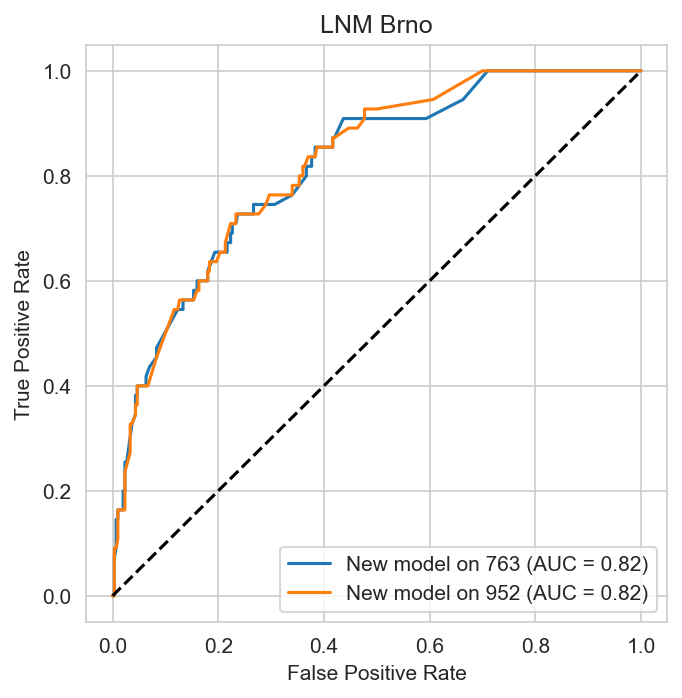

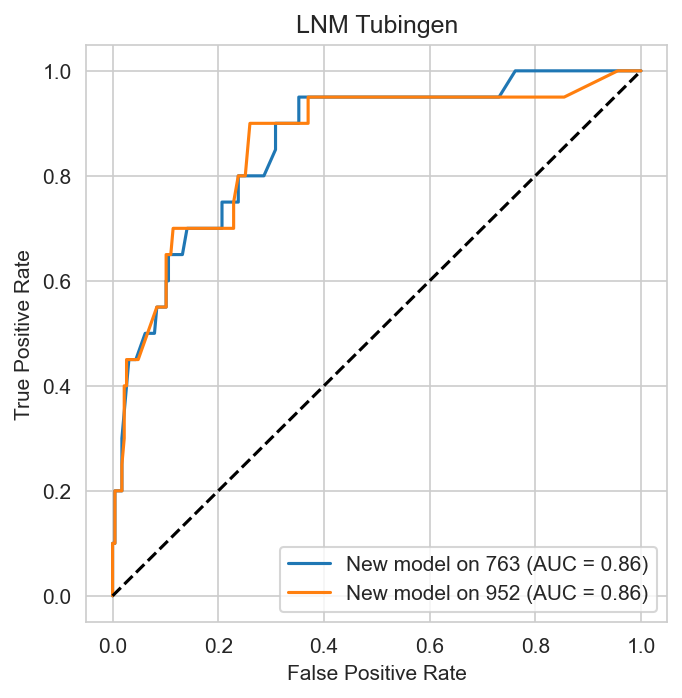

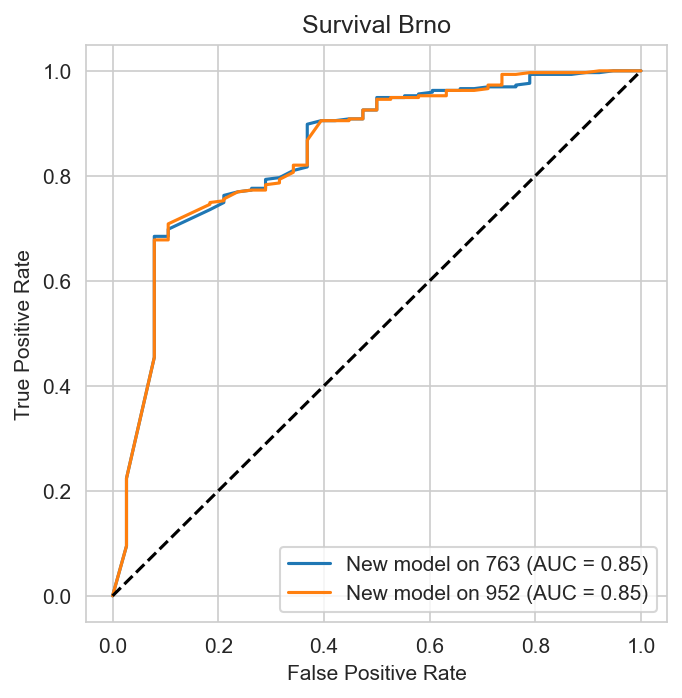

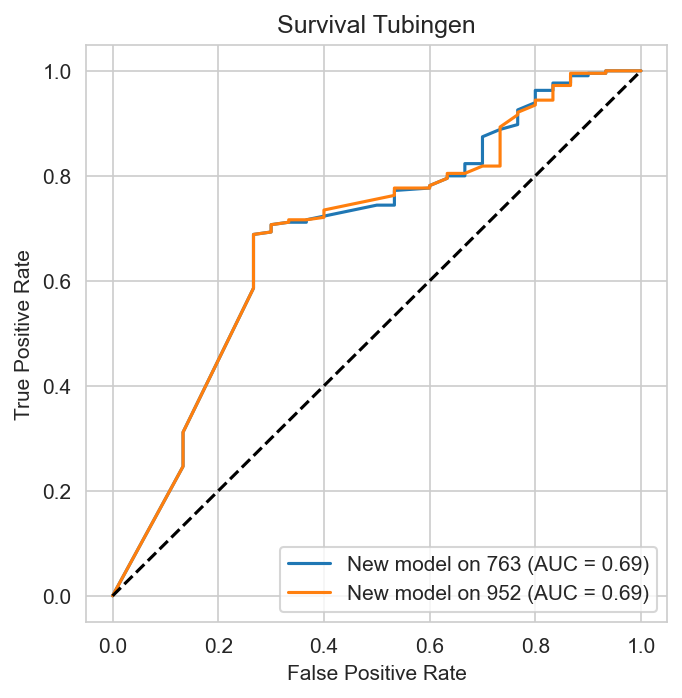

In [7]:
# Create ROC curves for the LNM and Survival predictions
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set_style("whitegrid")
# Set the output as png
set_matplotlib_formats('png', 'pdf')
plt.rcParams['figure.dpi'] = 150

# Create the ROC curves
fpr_net1_Brno_LNM, tpr_net1_Brno_LNM, _ = roc_curve(LNM_target_brno, net1_Brno_LNM_res)
fpr_net1_Brno_Surv, tpr_net1_Brno_Surv, _ = roc_curve(Surv_target_brno, net1_Brno_Surv_res)

fpr_net1_Tubingen_LNM, tpr_net1_Tubingen_LNM, _ = roc_curve(LNM_target_tubingen, net1_Tubingen_LNM_res)
fpr_net1_Tubingen_Surv, tpr_net1_Tubingen_Surv, _ = roc_curve(Surv_target_tubingen, net1_Tubingen_Surv_res)

fpr_net2_Brno_LNM, tpr_net2_Brno_LNM, _ = roc_curve(LNM_target_brno, net2_Brno_LNM_res)
fpr_net2_Brno_Surv, tpr_net2_Brno_Surv, _ = roc_curve(Surv_target_brno, net2_Brno_Surv_res)

fpr_net2_Tubingen_LNM, tpr_net2_Tubingen_LNM, _ = roc_curve(LNM_target_tubingen, net2_Tubingen_LNM_res)
fpr_net2_Tubingen_Surv, tpr_net2_Tubingen_Surv, _ = roc_curve(Surv_target_tubingen, net2_Tubingen_Surv_res)

# Create the plot

plot, ax = plt.subplots(1, 1, figsize=(5, 5))

# Plot the LNM ROC curves, AUC scores in legend, and diagonal line
ax.plot(fpr_net1_Brno_LNM, tpr_net1_Brno_LNM, label=f"New model on 763 (AUC = {round(roc_auc_score(LNM_target_brno, net1_Brno_LNM_res), 2)})")
ax.plot(fpr_net2_Brno_LNM, tpr_net2_Brno_LNM, label=f"New model on 952 (AUC = {round(roc_auc_score(LNM_target_brno, net2_Brno_LNM_res), 2)})")

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('LNM Brno')
ax.legend(loc="lower right")

plot, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(fpr_net1_Tubingen_LNM, tpr_net1_Tubingen_LNM, label=f"New model on 763 (AUC = {round(roc_auc_score(LNM_target_tubingen, net1_Tubingen_LNM_res), 2)})")
ax.plot(fpr_net2_Tubingen_LNM, tpr_net2_Tubingen_LNM, label=f"New model on 952 (AUC = {round(roc_auc_score(LNM_target_tubingen, net2_Tubingen_LNM_res), 2)})")

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('LNM Tubingen')
ax.legend(loc="lower right")

# Plot the Survival ROC curves, AUC scores in legend, and diagonal line
plot, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(fpr_net1_Brno_Surv, tpr_net1_Brno_Surv, label=f"New model on 763 (AUC = {round(roc_auc_score(Surv_target_brno, net1_Brno_Surv_res), 2)})")
ax.plot(fpr_net2_Brno_Surv, tpr_net2_Brno_Surv, label=f"New model on 952 (AUC = {round(roc_auc_score(Surv_target_brno, net2_Brno_Surv_res), 2)})")

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Survival Brno')
ax.legend(loc="lower right")

plot, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(fpr_net1_Tubingen_Surv, tpr_net1_Tubingen_Surv, label=f"New model on 763 (AUC = {round(roc_auc_score(Surv_target_tubingen, net1_Tubingen_Surv_res), 2)})")
ax.plot(fpr_net2_Tubingen_Surv, tpr_net2_Tubingen_Surv, label=f"New model on 952 (AUC = {round(roc_auc_score(Surv_target_tubingen, net2_Tubingen_Surv_res), 2)})")

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Survival Tubingen')
ax.legend(loc="lower right")




# When using the whole evidence set

In [8]:
# Complete evidence set
evidence_columns = ["ER", "PR", "p53", "L1CAM", "CA125", "Platelets", "Cytology", "MRI_MI", "MSI", "POLE", "PostoperativeGrade", "MyometrialInvasion", "LVSI"]
# network specific evidence
net1_nodes = net1.names()
net2_nodes = net2.names()

# select evidences present in both nodes and evidence columns
evi_net1_brno = [x for x in evidence_columns if x in net1_nodes and x in df_brno.columns]
evi_net1_tubingen = [x for x in evidence_columns if x in net1_nodes and x in df_tubingen.columns]

evi_net2_brno = [x for x in evidence_columns if x in net2_nodes and x in df_brno.columns]
evi_net2_tubingen = [x for x in evidence_columns if x in net2_nodes and x in df_tubingen.columns]


In [9]:
# Get probabilities
net1_Brno_LNM, net1_Brno_Surv = getProbabilities(net1, df_brno_LNM[evi_net1_brno], df_brno_surv[evi_net1_brno])
net1_Tubingen_LNM, net1_Tubingen_Surv = getProbabilities(net1, df_tubingen_LNM[evi_net1_tubingen], df_tubingen_surv[evi_net1_tubingen])

net2_Brno_LNM, net2_Brno_Surv = getProbabilities(net2, df_brno_LNM[evi_net2_brno], df_brno_surv[evi_net2_brno])
net2_Tubingen_LNM, net2_Tubingen_Surv = getProbabilities(net2, df_tubingen_LNM[evi_net2_tubingen], df_tubingen_surv[evi_net2_tubingen])

# Probabilities extract
net1_Brno_LNM_res = getProbResults(net1_Brno_LNM, 1)
net1_Brno_Surv_res = getProbResults(net1_Brno_Surv, 1)

net1_Tubingen_LNM_res = getProbResults(net1_Tubingen_LNM, 1)
net1_Tubingen_Surv_res = getProbResults(net1_Tubingen_Surv, 1)

net2_Brno_LNM_res = getProbResults(net2_Brno_LNM, 1)
net2_Brno_Surv_res = getProbResults(net2_Brno_Surv, 1)\

net2_Tubingen_LNM_res = getProbResults(net2_Tubingen_LNM, 1)
net2_Tubingen_Surv_res = getProbResults(net2_Tubingen_Surv, 1)


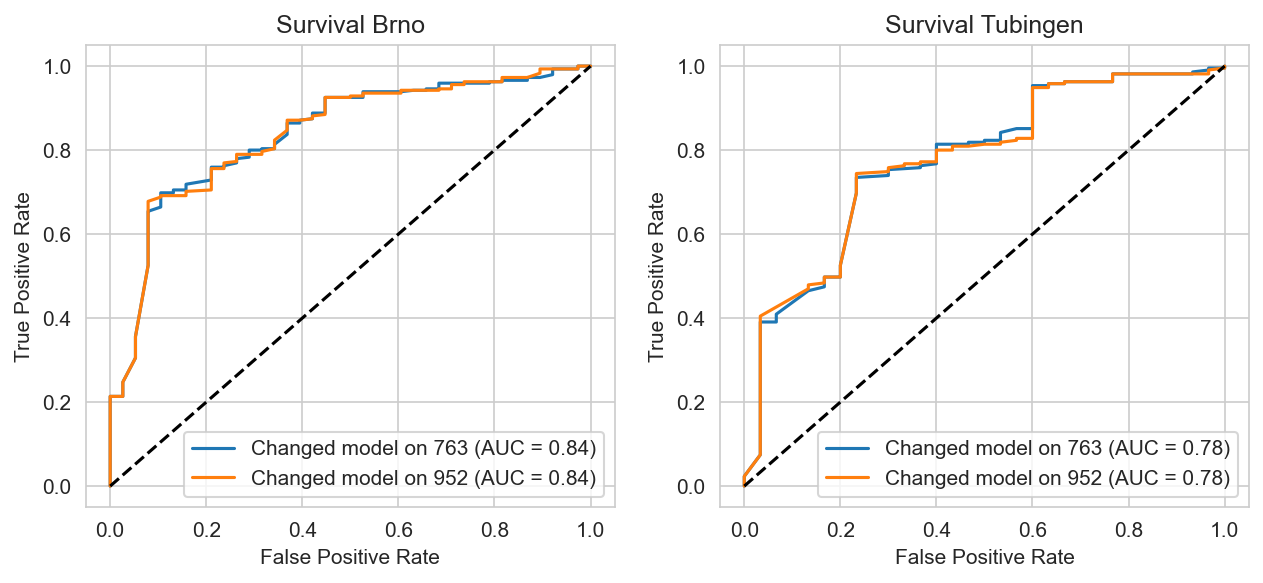

In [10]:
# Create ROC curves for the Survival predictions
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
import seaborn as sns

# get ROC
fpr_net1_Brno_Surv, tpr_net1_Brno_Surv, _ = roc_curve(Surv_target_brno, net1_Brno_Surv_res)

fpr_net1_Tubingen_Surv, tpr_net1_Tubingen_Surv, _ = roc_curve(Surv_target_tubingen, net1_Tubingen_Surv_res)

fpr_net2_Brno_Surv, tpr_net2_Brno_Surv, _ = roc_curve(Surv_target_brno, net2_Brno_Surv_res)

fpr_net2_Tubingen_Surv, tpr_net2_Tubingen_Surv, _ = roc_curve(Surv_target_tubingen, net2_Tubingen_Surv_res)

# Create the plot
fig, ax = plt.subplots(1,2, figsize=(10, 4))

# Plot the Survival ROC curves, AUC scores in legend, and diagonal line
ax[0].plot(fpr_net1_Brno_Surv, tpr_net1_Brno_Surv, label=f"Changed model on 763 (AUC = {round(roc_auc_score(Surv_target_brno, net1_Brno_Surv_res), 2)})")
ax[0].plot(fpr_net2_Brno_Surv, tpr_net2_Brno_Surv, label=f"Changed model on 952 (AUC = {round(roc_auc_score(Surv_target_brno, net2_Brno_Surv_res), 2)})")

ax[0].plot([0,1], [0,1], 'k--')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Survival Brno')
ax[0].legend(loc="lower right")

ax[1].plot(fpr_net1_Tubingen_Surv, tpr_net1_Tubingen_Surv, label=f"Changed model on 763 (AUC = {round(roc_auc_score(Surv_target_tubingen, net1_Tubingen_Surv_res), 2)})")
ax[1].plot(fpr_net2_Tubingen_Surv, tpr_net2_Tubingen_Surv, label=f"Changed model on 952 (AUC = {round(roc_auc_score(Surv_target_tubingen, net2_Tubingen_Surv_res), 2)})")

ax[1].plot([0,1], [0,1], 'k--')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Survival Tubingen')
ax[1].legend(loc="lower right")



